This aims to reproduce [this paper](https://fedimser.github.io/download/articles/Percolation2012.pdf) which I have written 10 years ago (for square grid only).

In [1]:
import numpy as np 
import numba
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
@numba.jit("i1[:,:](i1[:,:],i1,i1,i1,i1)")
def gol_step(field, b_min, b_max, s_min, s_max):
    n, m = field.shape
    new_field = np.zeros_like(field)
    for i in range(n):
        im1 = (i-1)%n
        ip1 = (i+1)%n
        for j in range(m):
            jm1 = (j-1)%m
            jp1 = (j+1)%m
            count = field[im1][jm1]
            count += field[im1][j]
            count += field[im1][jp1]
            count += field[i][jm1]
            count += field[i][jp1]
            count += field[ip1][jm1]
            count += field[ip1][j]
            count += field[ip1][jp1]
            if field[i][j]==1:
                if count >= s_min and count <= s_max:
                    new_field[i][j] = 1
            else:
                if count >= b_min and count <= b_max:
                    new_field[i][j] = 1
    return new_field

class CaRule():
    def __init__(self, s_min=2, s_max=3, b_min=3, b_max=3):
        assert 0 <= s_min <= s_max <= 8
        assert 0 <= b_min <= b_max <= 8
        self.b_min = b_min
        self.b_max = b_max
        self.s_min = s_min
        self.s_max = s_max
        
    def rule_name(self):
        return 's%d%d/b%d%d' % (self.s_min, self.s_max, self.b_min, self.b_max)

    def init_random_field(self, size, concentration):
        self.field = np.array(np.random.uniform(0.0, 1.0, size=(size, size)) < concentration, dtype = np.int8)
        
    def step(self):
        self.field = gol_step(self.field, self.b_min, self.b_max, self.s_min, self.s_max)

In [3]:
field_size = 50
datapoints = 101
repeats_per_datapoint = 50

def percolation_experiment(rule, size=25, init_conc=0.5, max_steps=1000):
    rule.init_random_field(size, init_conc)
    conc = [np.sum(rule.field)]
    steps_no_change = 0
    for i in range(max_steps):
        rule.step()
        new_conc = np.sum(rule.field)
        if new_conc == conc[-1]:
            steps_no_change +=1
        else:
            steps_no_change = 0
        conc.append(new_conc)
        if steps_no_change >= 10:
            break
    conc = np.array(conc) / (size*size)
    final_conc = np.mean(conc[-10:])           
    return {
        'conc_chart': conc, 
        'final_conc': final_conc
    }
    

def full_percolation_experiment(rule):
    init_conc = np.linspace(0, 1, datapoints)
    final_conc = []
    for k in init_conc:
        fc = []
        for _ in range(repeats_per_datapoint):
            result = percolation_experiment(rule, size=field_size, init_conc=k)
            fc.append(result['final_conc'])
        final_conc.append(np.mean(fc))
    return {
        'name': rule.rule_name(),
        'init_conc': init_conc,
        'final_conc': np.array(final_conc)
    }

rules = [
    CaRule(s_min=2, s_max=3, b_min=3, b_max=3),
    CaRule(s_min=2, s_max=8, b_min=3, b_max=3),
    CaRule(s_min=2, s_max=8, b_min=3, b_max=8)
] + [
    CaRule(s_min=i, s_max=8, b_min=i, b_max=8)
    for i in range(0, 9)
]

results = dict()
for rule in rules:
    name = rule.rule_name()
    print("Running experiment for rule: " + name)
    results[name] = full_percolation_experiment(rule)

Running experiment for rule: s23/b33
Running experiment for rule: s28/b33
Running experiment for rule: s28/b38
Running experiment for rule: s08/b08
Running experiment for rule: s18/b18
Running experiment for rule: s28/b28
Running experiment for rule: s38/b38
Running experiment for rule: s48/b48
Running experiment for rule: s58/b58
Running experiment for rule: s68/b68
Running experiment for rule: s78/b78
Running experiment for rule: s88/b88


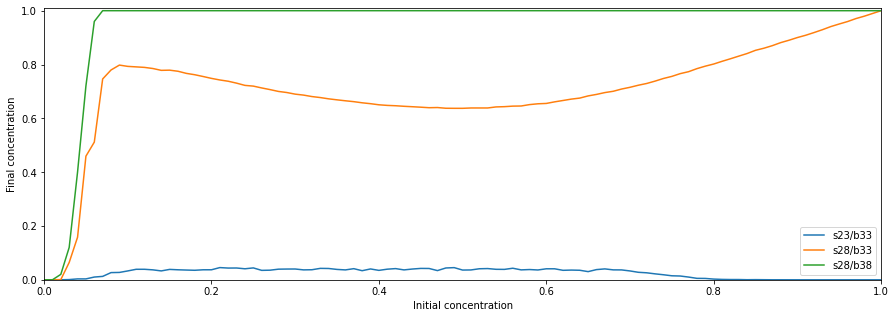

In [4]:
plt.figure(figsize=(15, 5))
for rule in ['s23/b33', 's28/b33', 's28/b38']:
    result = results[rule]
    plt.plot(result['init_conc'], result['final_conc'], label=rule)
plt.xlim([0,1])
plt.ylim([0,1.01])
plt.legend()
plt.xlabel('Initial concentration')
plt.ylabel('Final concentration')
plt.show()

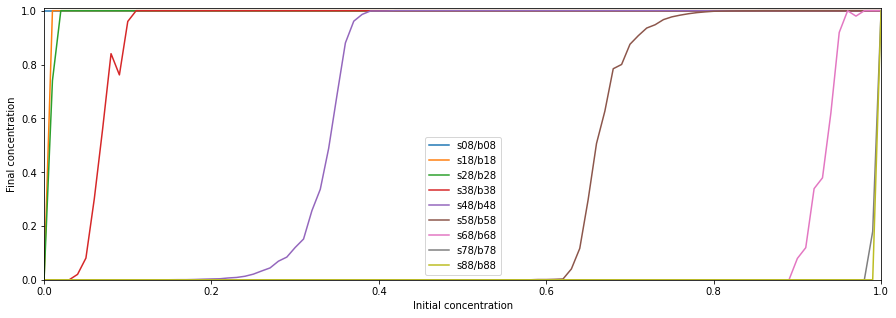

In [5]:
plt.figure(figsize=(15, 5))
for rule in ['s%d8/b%d8' % (i, i) for i in range(9)]:
    result = results[rule]
    plt.plot(result['init_conc'], result['final_conc'], label=rule)
plt.xlim([0,1])
plt.ylim([0,1.01])
plt.legend()
plt.xlabel('Initial concentration')
plt.ylabel('Final concentration')
plt.show()

### Finding critical coefficients

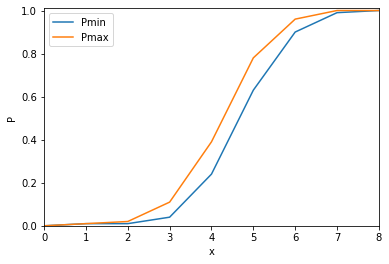

,Rule,Pmin,Pmax,R^2,β,C
0,s38/b38,0.04,0.11,0.966024,1.280746,10.615721
1,s48/b48,0.24,0.39,0.960067,1.648323,0.987850
2,s58/b58,0.63,0.78,0.934629,0.711228,18.561849
3,s68/b68,0.90,0.96,0.986936,1.176530,12.486946


In [6]:
from scipy import stats

p_min_chart = []
p_max_chart = []
results_table = []

for x in range(9):
    rule = 's%d8/b%d8' % (x, x)
    result = results[rule]
    init_conc = result['init_conc']
    final_conc = result['final_conc']
    
    p_min, p_max = 0, 1.0
    # p_min := min k such that K(k) >= 1%
    # p_max := min k such that K(k) > 99%
    for i in range(len(init_conc)-1 , -1, -1):
        if (final_conc[i] >= 0.01):
            p_min = init_conc[i]
        if (final_conc[i] > 0.99):
            p_max = init_conc[i] 
    p_min_chart.append(p_min)
    p_max_chart.append(p_max)

    if x>=3 and x<=6:
        ln_K = []
        ln_k_minus_p_min = []
        for i in range(len(init_conc)):
            k = init_conc[i]
            K = final_conc[i]
            if k > p_min and k <= p_max:
                ln_K.append(np.log(K*100))
                ln_k_minus_p_min.append(np.log(100*(k - p_min)))

        lin_reg = stats.linregress(ln_k_minus_p_min, ln_K)
        ln_C = lin_reg.intercept
        beta = lin_reg.slope        
        results_table.append([rule, p_min, p_max, lin_reg.rvalue, beta, np.exp(ln_C)])

    
plt.plot(list(range(9)), p_min_chart, label = 'Pmin')
plt.plot(list(range(9)), p_max_chart, label = 'Pmax')
plt.xlim([0,8])
plt.ylim([0,1.01])
plt.legend()
plt.xlabel('x')
plt.ylabel('P')
plt.show()
   
pd.DataFrame(results_table, columns=['Rule', 'Pmin', 'Pmax', 'R^2', 'β', 'C'])